# Supervised Machine Learning Final Assignment
Date: Aug2023

Data Source: https://www.kaggle.com/datasets/krantiswalke/bank-personal-loan-modelling

# Goals
1. Explain the dataset
2. Explore the data
3. Clean & Transform as needed
4. Train a supervised model
5. Test the supervised model
6. Explore improvement possibilities
7. Discussion & Conclusions

# The Data
This data contains financial information of 5000 bank customers' and results from a previous personal loan campaign. The goal is to create a model to target the people that are more likely to respond positively to loan marketing (i.e. taking out a personal loan) for future loan campaigns. The dataset contains the following fields:
1. ID : Customer ID
2. Age : Customer's age in completed years
3. Experience : #years of professional experience
4. Income : Annual income of the customer ($000)
5. ZIP Code : Home Address ZIP code.
6. Family : Family size of the customer
7. CCAvg : Avg. spending on credit cards per month ($000)
8. Education : Education Level.
    - 1: Undergrad;
    - 2: Graduate;
    - 3: Advanced/Professional
9. Mortgage : Value of house mortgage if any. ($000)
10. Personal Loan : Did this customer accept the personal loan offered in the last campaign?
11. Securities Account : Does the customer have a securities account with the bank?
12. CD Account : Does the customer have a certificate of deposit (CD) account with the bank?
13. Online : Does the customer use internet banking facilities?
14. Credit card : Does the customer use a credit card issued by the bank?



In [1]:
# Import modules
import polars as pl
import altair as alt
import pgeocode, requests
import numpy as np
from seaborn import heatmap
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
# Import the data
url = "https://raw.githubusercontent.com/nsxydis/Supervised-Final/main/Bank_Personal_Loan_Modelling.csv"
df = pl.read_csv(url)

# Convert all the columns to lower case
df.columns = [col.lower() for col in df.columns]

# Exploration
Next we'll look at an overview of the data: column types, potential null values, etc.

In [3]:
df.head()

id,age,experience,income,zip code,family,ccavg,education,mortgage,personal loan,securities account,cd account,online,creditcard
i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64
1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [4]:
df.to_pandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   experience          5000 non-null   int64  
 3   income              5000 non-null   int64  
 4   zip code            5000 non-null   int64  
 5   family              5000 non-null   int64  
 6   ccavg               5000 non-null   float64
 7   education           5000 non-null   int64  
 8   mortgage            5000 non-null   int64  
 9   personal loan       5000 non-null   int64  
 10  securities account  5000 non-null   int64  
 11  cd account          5000 non-null   int64  
 12  online              5000 non-null   int64  
 13  creditcard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


# Clean and Transform
Based on the initial viewing of the data we don't have any null values and most of the data are integer values (other than ccavg which is a float). To see if we can extract any additional data, we'll add the longitude and latitude values to our dataframe.

In [5]:
# Convert zipcode to longitude & latitude
# NOTE: To save on time, we'll make a dataframe of all the unique zip codes first
nomi = pgeocode.Nominatim('us')

def getZip(zipcode):
    '''Scrapes zipcode data from the web if we get a null value from pgeocode'''
    url = f"https://uszipcodesbystate.com/zip/{zipcode}"
    r = requests.get(url)

    # Find the longitude and latitude
    next = False
    now = False
    for line in r.text.split(' '):
        if 'name="geo.position' in line:
            next = True
        if next:
            if now == False:
                now = True
            else:
                location = line
                next = False

    # Clean up the location data
    try:
        location = location.replace('content=', '')
        location = location.replace('"', '')
        location = location.split(";")
        lat, lon = float(location[0]), float(location[1])
    except:
        # Had some trouble finding data on this point
        if zipcode == 96651:
            lat, lon = 38.81781, -120.92925
        else:
            print(f"Issue finding zip code: {zipcode}")
            lat, lon = 0, 0

    return lon, lat

# Make a dictionary of all the unique zipcodes
zipcodes = {
    'zip'   : [],
    'lon'   : [],
    'lat'   : []
}
for zipcode in df['zip code'].unique().to_list():
    area = nomi.query_postal_code(f"{zipcode}")
    
    zipcodes['zip'].append(zipcode)
    lon = float(area['longitude'])
    lat = float(area['latitude'])
    if np.isnan(lon) or np.isnan(lat):
        lon, lat = getZip(zipcode)
    zipcodes['lon'].append(lon)
    zipcodes['lat'].append(lat)

# Convert to a dataframe
zipcodes = pl.DataFrame(zipcodes)

# Make a function to add the longitude and latitude
def lonlat(zipcode, type):
    area = zipcodes.filter(pl.col('zip') == zipcode)

    if type == "lon":
        val = area['lon'][0]
    elif type == 'lat':
        val = area['lat'][0]
    else:
        val = -1.0

    return val
    
# Add the data to our dataframe
df = df.with_columns(pl.col('zip code').apply(lambda x: lonlat(x, 'lon')).alias('longitude'))
df = df.with_columns(pl.col('zip code').apply(lambda x: lonlat(x, 'lat')).alias('latitude'))


In [6]:
# Reorder columns
cols = df.columns
cols.remove('personal loan')
reorder = ['personal loan']
for col in cols:
    reorder.append(col)
df = df[reorder]

# Take a look at the correlation matrix
df.to_pandas().corr()

,personal loan,id,age,experience,income,zip code,family,ccavg,education,mortgage,securities account,cd account,online,creditcard,longitude,latitude
personal loan,1.000000,-0.024801,-0.007726,-0.007413,0.502462,0.000107,0.061367,0.366889,0.136722,0.142095,0.021954,0.316355,0.006278,0.002802,-0.002444,-0.007148
id,-0.024801,1.000000,-0.008473,-0.008326,-0.017695,0.013432,-0.016797,-0.024675,0.021463,-0.013920,-0.016972,-0.006909,-0.002528,0.017028,-0.019771,0.015296
age,-0.007726,-0.008473,1.000000,0.994215,-0.055269,-0.029216,-0.046418,-0.052012,0.041334,-0.012539,-0.000436,0.008043,0.013702,0.007681,0.020405,-0.024549
experience,-0.007413,-0.008326,0.994215,1.000000,-0.046574,-0.028626,-0.052563,-0.050077,0.013152,-0.010582,-0.001232,0.010353,0.013898,0.008967,0.020445,-0.024754
income,0.502462,-0.017695,-0.055269,-0.046574,1.000000,-0.016410,-0.157501,0.645984,-0.187524,0.206806,-0.002616,0.169738,0.014206,-0.002385,0.012302,-0.027389
zip code,0.000107,0.013432,-0.029216,-0.028626,-0.016410,1.000000,0.011778,-0.004061,-0.017377,0.007383,0.004704,0.019972,0.016990,0.007691,-0.798365,0.700116
family,0.061367,-0.016797,-0.046418,-0.052563,-0.157501,0.011778,1.000000,-0.109275,0.064929,-0.020445,0.019994,0.014110,0.010354,0.011588,-0.019601,0.027488
ccavg,0.366889,-0.024675,-0.052012,-0.050077,0.645984,-0.004061,-0.109275,1.000000,-0.136124,0.109905,0.015086,0.136534,-0.003611,-0.006689,0.003746,-0.016186
education,0.136722,0.021463,0.041334,0.013152,-0.187524,-0.017377,0.064929,-0.136124,1.000000,-0.033327,-0.010812,0.013934,-0.015004,-0.011014,0.017051,-0.014972
mortgage,0.142095,-0.013920,-0.012539,-0.010582,0.206806,0.007383,-0.020445,0.109905,-0.033327,1.000000,-0.005411,0.089311,-0.005995,-0.007231,0.000369,-0.001959


<Axes: >

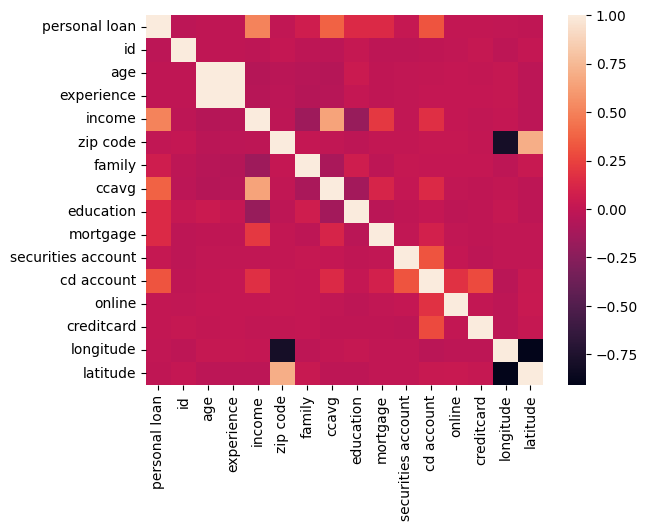

In [7]:
# Create a heatmap
heatmap(df.to_pandas().corr())

# EDA Results
It looks like adding the longitude & latitude data didn't add a significant amount of information to the dataset, so for purposes of the model we won't evaluate those fields. 

Since the target value is the personal loan field, we can look at the correlation matrix to identify the strongest categories to work with. Based on these results, we'll be using the following fields for our initial model:
1. income
2. ccavg
3. cd account
4. mortgage

NOTE: There does appear to be a high correlation between income and ccavg -- it may be worth removing this field later to improve model performance. 

# Train a Supervised Classification Model
For this assignment we'll use the k-nearest neighbors (KNN) method to classify the data. We'll go through the following steps:
1. Split the data into train/test groups
2. Fit our model
3. Predict the test data results

In [8]:
# Set the classifier
class knn:
    def __init__(self, data, neighbors, categories):
        # Initialize the data
        self.y = data[['personal loan']].to_pandas()
        self.data = data[categories].to_pandas()
        self.print = True

        # Set up the classifier
        self.classifier = KNN(n_neighbors = neighbors)

        # Split the data
        self.split()

        # Train the data
        self.train()

    def split(self):
        '''Split the data into train test groups'''
        self.x_train, self.x_test, self.y_train, self.y_test = \
        train_test_split(self.data, self.y, test_size = .3, random_state = 42)

    def train(self):
        '''Trains the knn classifier'''
        self.classifier.fit(self.x_train, self.y_train['personal loan'].ravel())

    def predict(self, x):
        '''Makes and returns predictions'''
        yp = self.classifier.predict(x)
        return yp
    
    def trainResults(self):
        '''Prints & returns the accuracy for the training data'''
        yp = self.predict(self.x_train)
        self.yp_train = yp

        # Calculate accuracy
        acc = sum(self.y_train['personal loan'] == yp) / len(yp)
        if self.print == True:
            print(f"Training Accuracy: {round(acc * 100, 2)}%")
        return acc

    def testResults(self):
        '''Prints & returns the accuracy for the test data'''
        yp = self.predict(self.x_test)
        self.yp_test = yp

        # Calculate accuracy
        acc = sum(self.y_test['personal loan'] == yp) / len(yp)
        if self.print == True:
            print(f"Test Accuracy: {round(acc * 100, 2)}%")
        return acc
    
    def confusion(self, type):
        '''Make a confusion matrix'''
        if type == 'train':
            try:
                title = "Training Confusion Matrix"
                yp = self.yp_train
                y = self.y_train
            except:
                print("You need to run self.trainResults() first!")
                return -1

        elif type == 'test':
            try:
                title = "Testing Confusion Matrix"
                yp = self.yp_test
                y = self.y_test
            except:
                print("You need to run self.testResults() first!")
                return -1
        
        conMatrix = confusion_matrix(y, yp)
        if self.print == True:
            print(title)
            print(conMatrix)

        return conMatrix
    

In [9]:
cat = ['income', 'ccavg', 'cd account', 'mortgage']
model = knn(df, neighbors = 3, categories = cat)
_ = model.trainResults()
_ = model.testResults()

Training Accuracy: 94.31%
Test Accuracy: 89.2%


# Initial Results
The initial results for the model look promising, with an accuracy of about 89%. We'll test if the earlier note is relevant -- does the model improve if we remove 'ccavg' since it has a high correlation with income?

In [10]:
cat = ['income', 'cd account', 'mortgage']
model = knn(df, neighbors = 3, categories = cat)
_ = model.trainResults()
_ = model.testResults()

Training Accuracy: 92.8%
Test Accuracy: 89.4%


# Model Improvements Part 1
We see that by removing the correlated category 'ccavg' that the test accuracy improves slightly. We'll try different numbers of neighbors to see if that also has an impact.

In [11]:
cat = ['income', 'cd account', 'mortgage']

model = knn(df, neighbors = 5, categories = cat)
_ = model.trainResults()
_ = model.testResults()

Training Accuracy: 92.77%
Test Accuracy: 90.33%


# Model Improvements Part 2
## Optimal number of neighbors
From the above we can see that increasing the number of neighbors had a positive effect on the test results. We'll take a deeper look to see what the optimal number of neighbors are.

In [12]:
# For making a dataframe
results = {
    'n'     : [],
    'type'  : [],
    'score' : [],
}

# Loop through different numbers of neighbors
for n in range(1, 11):
    # print(f"Number of neighbors: {n}")
    model = knn(df, neighbors = n, categories = cat)
    model.print = False

    # Append to our dictionary...
    # For the training data...
    results['n'].append(n)
    results['type'].append('train')
    results['score'].append(model.trainResults())

    # For the testing data...
    results['n'].append(n)
    results['type'].append('test')
    results['score'].append(model.testResults())

    # print()

# Convert to a dataframe
results = pl.DataFrame(results)

In [13]:
# Plot the results
title = [
    "Train versus Test Accuracy with different",
    "numbers of neighbors for KNN"
]
accuracyChart = alt.Chart(results.to_pandas(), title = title).mark_line().encode(
    x = alt.X('n', title = "Number of Neighbors for KNN"),
    y = alt.Y('acc:Q', title = "Accuracy (percent)", scale = alt.Scale(domain = [85, 100])),
    color = alt.Color('type', title = 'Data Type', scale = alt.Scale(domain = ['train', 'test'])),
    tooltip = [
        alt.Tooltip('type', title = "Data Type"),
        alt.Tooltip('score', title = 'Accuracy')
    ]
).transform_calculate(
    acc = 'datum.score * 100'
)
accuracyChart

alt.Chart(...)

# Model Improvements Discussion
From the above we can see that the model improves with larger numbers of neighbors, but that improvement tapers off at around 7 neighbors. Models tend to generalize better with more neighbors, but having too many neighbors can impact performance as well. So, we'll choose 7 neighbors for the next model and compare the results.

In [14]:
# Make the model
model = knn(df, neighbors = 7, categories = cat)
model.trainResults()
model.testResults()

# Prevent printing the output
model.print = False
trainCon = model.confusion('train')
testCon = model.confusion('test')


Training Accuracy: 92.69%
Test Accuracy: 90.6%


Training Confusion Matrix


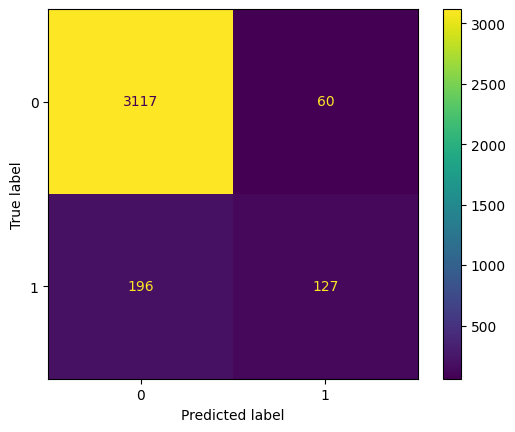

In [15]:
# Plot the training confusion matrix
print("Training Confusion Matrix")
_ = ConfusionMatrixDisplay(trainCon).plot()

Testing Confusion Matrix


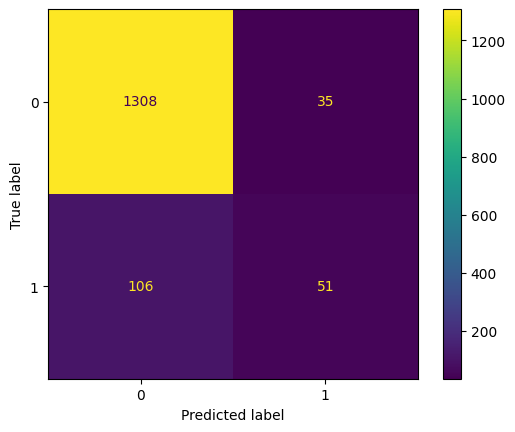

In [16]:
# Plot the testing confusion matrix
print("Testing Confusion Matrix")
_ = ConfusionMatrixDisplay(testCon).plot()

In [17]:
# Basic Results for the test data
# NOTE: Some of this data is redundant, but is important to state anyway
def reportConfusion(matrix):
    '''Convert the numerical confusion matrix to real words'''
    tn = matrix[0][0]
    fn = matrix[1][0]
    fp = matrix[0][1]
    tp = matrix[1][1]

    print("Based on the test results of the supervised model:")
    ans = round(tn / (tn + tp) * 100, 2)
    print(f"{ans}% of people that would reject the loan offer would be correctly identified.")
    ans = round(tp / (tp + fn) * 100, 2)
    print(f"{ans}% of people that would accept loan offers would be correctly identified.")
    ans = round(fp / (fp + tp) * 100, 2)
    print(f"{ans}% of people contacted would reject a loan offer.")
    ans = round(fn / (fn + tp) * 100, 2)
    print(f"{ans}% of people that would accept a loan offer would be missed.")

reportConfusion(testCon)

Based on the test results of the supervised model:
96.25% of people that would reject the loan offer would be correctly identified.
32.48% of people that would accept loan offers would be correctly identified.
40.7% of people contacted would reject a loan offer.
67.52% of people that would accept a loan offer would be missed.


# Round 2 of Model Improvements
From the above we can see that there were a large number of potential loan applicants that were missed by the current settings. Lets run through the models again and look for results that minimize the number of false negatives.

In [18]:
results = {
    'n'     : [],
    'type'  : [],
    'fn'    : [], # Rate of false negatives
}

for n in range(1, 11):
    # Make the model
    model = knn(df, neighbors = n, categories = cat)

    # Prevent printing the output
    model.print = False

    # Test & Train
    model.trainResults()
    model.testResults()

    # Make the confusion matricies...
    # ...for training data
    trainCon = model.confusion('train')
    results['n'].append(n)
    results['type'].append('train')

    # Get the rate of false negatives
    fn = trainCon[1][0]
    tot = trainCon[1][0] + trainCon[1][1]
    results['fn'].append(fn / tot)


    # ...for testing data 
    testCon = model.confusion('test')
    results['n'].append(n)
    results['type'].append('test')
    
    # Get the rate of false negatives
    fn = testCon[1][0]
    tot = testCon[1][0] + testCon[1][1]
    results['fn'].append(fn / tot)

# Convert to a dataframe
results = pl.DataFrame(results)    

In [19]:
# Plot the rate of false negatives
title = ['Rate of false negatives in Train vs. Test', 'data based on the number of neighbors for KNN']
falseNegatives = alt.Chart(results.to_pandas(), title = title).mark_line().encode(
    x = alt.X('n', title = "Number of Neighbors"),
    y = alt.Y('fn', title = "Rate of false positives"),
    color = alt.Color('type', title = "Data Type"),
    tooltip = [
        alt.Tooltip('type', title = "Data Type"),
        alt.Tooltip('fn', title = "False Negative Rate")
    ]
)
accuracyChart | falseNegatives

alt.HConcatChart(...)

# Round 2 of Model improvements, graphs
Based on the above graphs, we see that the lowest number of false negatives in the test results is when the number of neighbors is 1, at about 57%. The next lowest is with the number of neighbors equal to 3, with about 59% false negatives. Banks would be most interested in having the lowest false negative rate, since that means a loan that they've missed out on. However, since using a low number of neighbors can lead to overfitting the data, we'll use 3 as the number of neighbors for the final model. Let's look at the confusion matrix for those settings.

In [20]:
# Make the model
model = knn(df, neighbors = 3, categories = cat)
model.trainResults()
model.testResults()

# Prevent printing the output
model.print = False
trainCon = model.confusion('train')
testCon = model.confusion('test')

Training Accuracy: 92.8%
Test Accuracy: 89.4%


Training Confusion Matrix


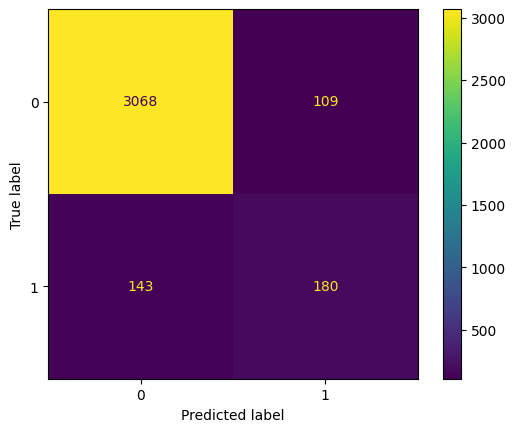

In [21]:
# Plot the training confusion matrix
print("Training Confusion Matrix")
_ = ConfusionMatrixDisplay(trainCon).plot()

Testing Confusion Matrix


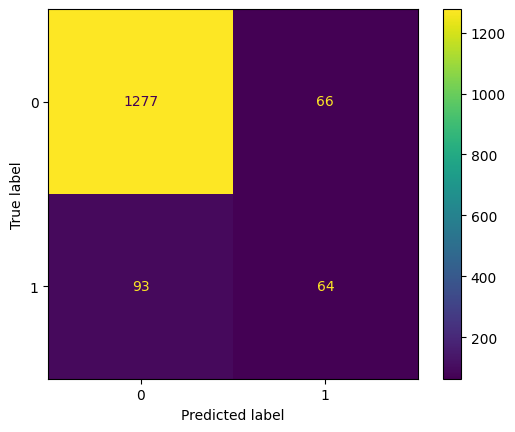

In [22]:
# Plot the testing confusion matrix
print("Testing Confusion Matrix")
_ = ConfusionMatrixDisplay(testCon).plot()

In [23]:
reportConfusion(testCon)

Based on the test results of the supervised model:
95.23% of people that would reject the loan offer would be correctly identified.
40.76% of people that would accept loan offers would be correctly identified.
50.77% of people contacted would reject a loan offer.
59.24% of people that would accept a loan offer would be missed.


# Conclusion
The final accuracy of the model is about 90%. However, as we identified in the confusion matrix, the true value of this model would depend on the situation the bank was in. For example if the cost of marketing was extremely high, perhaps people are going door to door or calling individuals, then this model could be a good fit as it reduces the number of interactions substantially. Alternatively if the cost of marketing was low, like sending out generic flyers to all the recipients, and the value of new loans was high, this model might not be as good because you'll potentially miss nearly 60% of the people that may have signed up for a personal loan. Ultimately there would have to be a cost-benefit calculation that determined the value of a new loan versus the cost of marketing before we could consider if this model is sufficient. 